In [192]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [193]:
url="https://www.data.gouv.fr/fr/datasets/r/b4ea7b4b-b7d1-4885-a099-71852291ff20"
df_test=pd.read_csv(url,sep = ';')
df_test=df_test.drop(["nb_test_h","nb_test_f","nb_pos_h","nb_pos_f"],axis=1)

In [194]:
df_test=df_test.drop(df_test[df_test["jour"]<"2020-03-18"].index)
df_test.head()

,dep,jour,clage_covid,nb_test,nb_pos
48,01,2020-03-18,0,37,8
49,01,2020-03-18,A,0,0
50,01,2020-03-18,B,15,1
51,01,2020-03-18,C,11,3
52,01,2020-03-18,D,4,3


In [195]:
url2="https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
df_hospital = pd.read_csv(url2,sep=';')
df_hospital.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


In [196]:
df_hospital = df_hospital.drop(df_hospital[(df_hospital["sexe"]==1) | (df_hospital["sexe"]==2 ) ].index).reset_index()
df_hospital = df_hospital.drop(["sexe",'index'],axis=1)
df_hospital.head()

,dep,jour,hosp,rea,rad,dc
0,01,2020-03-18,2,0,1,0
1,02,2020-03-18,41,10,18,11
2,03,2020-03-18,4,0,1,0
3,04,2020-03-18,3,1,2,0
4,05,2020-03-18,8,1,9,0


In [198]:
df_dep = pd.merge(df_hospital,df_test,on=['dep','jour'])
df_dep=df_dep.sort_values(['dep','jour'])

In [199]:
df_dep.head(10)

,dep,jour,hosp,rea,rad,dc,clage_covid,nb_test,nb_pos
0,01,2020-03-18,2,0,1,0,0,37,8
1,01,2020-03-18,2,0,1,0,A,0,0
2,01,2020-03-18,2,0,1,0,B,15,1
3,01,2020-03-18,2,0,1,0,C,11,3
4,01,2020-03-18,2,0,1,0,D,4,3
5,01,2020-03-18,2,0,1,0,E,7,1
606,01,2020-03-19,2,0,1,0,0,82,13
607,01,2020-03-19,2,0,1,0,A,1,0
608,01,2020-03-19,2,0,1,0,B,41,2
609,01,2020-03-19,2,0,1,0,C,21,8


In [109]:
df = pd.read_csv('datasets/covid_19_data.csv')

In [110]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [74]:
df['Country/Region'].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

In [75]:
df = df.drop(df[(df["Country/Region"]=="('St. Martin',)")].index)

In [76]:
countries = df['Country/Region'].unique()
countries.sort()
print(countries)

[' Azerbaijan' 'Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Barbados'
 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Burma' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Cape Verde' 'Cayman Islands' 'Central African Republic' 'Chad'
 'Channel Islands' 'Chile' 'Colombia' 'Comoros' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Costa Rica' 'Croatia' 'Cuba' 'Curacao' 'Cyprus'
 'Czech Republic' 'Denmark' 'Diamond Princess' 'Djibouti' 'Dominica'
 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia'
 'Faroe Islands' 'Fiji' 'Finland' 'France' 'French Guiana' 'Gabon'
 'Gambia' 'Gambia, The' 'Georgia' 'Germany' 'Ghana' 'Gibraltar' 'Greece'
 'Greenland' 'Grenada' 'Guadeloupe' 'Gua

In [82]:
df_country=df.groupby(['Country/Region','ObservationDate'])[["Confirmed","Deaths","Recovered"]].sum().reset_index()
df_country.head(30)

,Country/Region,ObservationDate,Confirmed,Deaths,Recovered
0,Azerbaijan,02/28/2020,1.0,0.0,0.0
1,Afghanistan,02/24/2020,1.0,0.0,0.0
2,Afghanistan,02/25/2020,1.0,0.0,0.0
3,Afghanistan,02/26/2020,1.0,0.0,0.0
4,Afghanistan,02/27/2020,1.0,0.0,0.0
5,Afghanistan,02/28/2020,1.0,0.0,0.0
6,Afghanistan,02/29/2020,1.0,0.0,0.0
7,Afghanistan,03/01/2020,1.0,0.0,0.0
8,Afghanistan,03/02/2020,1.0,0.0,0.0
9,Afghanistan,03/03/2020,1.0,0.0,0.0


In [83]:
df_france=df_country[(df_country["Country/Region"]=="France")]
df_france.head(30)

,Country/Region,ObservationDate,Confirmed,Deaths,Recovered
12088,France,01/24/2020,2.0,0.0,0.0
12089,France,01/25/2020,3.0,0.0,0.0
12090,France,01/26/2020,3.0,0.0,0.0
12091,France,01/27/2020,3.0,0.0,0.0
12092,France,01/28/2020,4.0,0.0,0.0
12093,France,01/29/2020,5.0,0.0,0.0
12094,France,01/30/2020,5.0,0.0,0.0
12095,France,01/31/2020,5.0,0.0,0.0
12096,France,02/01/2020,6.0,0.0,0.0
12097,France,02/02/2020,6.0,0.0,0.0


In [86]:
df_france.iloc[-1][:]

Country/Region         France
ObservationDate    09/23/2020
Confirmed              508456
Deaths                  31447
Recovered               96498
Name: 12331, dtype: object

In [80]:
y_data = np.array([
    df_france['Confirmed_acc'],
    df_france['Deaths_acc'],
    df_france['Recovered']
])
labels = ['Confirmed', 'Deaths', 'Recovered']
colors = ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(49,130,189)']
line_size = [2, 4, 2]

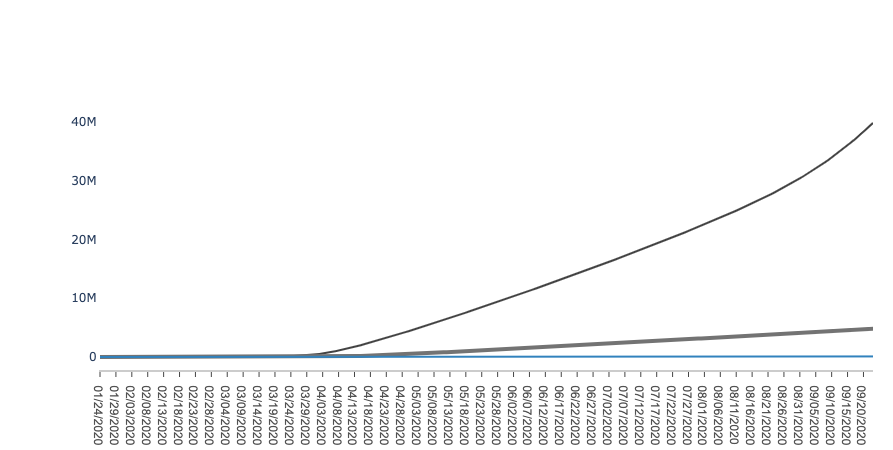

In [27]:
fig = go.Figure()

for i in range(0, 3):
    fig.add_trace(go.Scatter(x=df_france['ObservationDate'], y=y_data[i], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=False,
    plot_bgcolor='white'
)

fig.show()